<a href="https://colab.research.google.com/github/dhanashrishah1306-svg/Hackathon_-Brain_Dead-/blob/main/Copy_of_Brain_Dead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement #
### ReelSense: Explainable Movie Recommender System with Diversity Optimization ###
ReelSense is a movie recommendation system challenge that goes beyond just predicting user ratings. The project involves:

1. Building personalized, explainable Top-K movie recommendations using hybrid approaches
2. Ensuring diversity and coverage to avoid popularity bias
3. Generating natural language explanations for each recommendation
4. Reporting metrics for ranking, diversity, and novelty


#### NoteBook Overview
1. Introduction
2. Data Preparation
3. Exploratory Analysis
4. Content-Based Filtering
5. Collaborative Filtering
6. Hybrid Recommendation System
7. Diversity & Explainability
8. Evaluation Metrics
9. Results
10. Acknowledgements

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


# Functions Defined

*mf_scores_for_user(user_id)*  function is a helper for Matrix Factorization (MF).
Actually it works as

*Given a user ID, return predicted preference scores for all movies based on MF.*

It is designed to be plugged into a hybrid recommender like:
Final score = α × Content score + (1 − α) × MF score

In [68]:
def mf_scores_for_user(user_id):
    if user_id not in pred_df.index:
        return pd.Series(0, index=movies_data['movieId'])
    return pred_df.loc[user_id]



*intra_list_diversity(recommended_movies)*

This function measures intra-list diversity of a recommendation list by comparing movie genres.
It computes the average Jaccard distance between all pairs of recommended movies, where higher values mean more genre dissimilarity.
If recommended movies share many genres, diversity is low; if they span different genres, diversity is high.
This helps evaluate whether recommendations avoid redundancy and promote varied content.

it accept parameters as recommended_movies which is a dataframe of recommended movies.

the function actually Splits genres for each movie,Computes Jaccard distance between every pair of movies then returns the average genre dissimilarity across all pairs

In [69]:
from itertools import combinations

def intra_list_diversity(recommended_movies):
    genres = recommended_movies['genres'].str.split('|')

    def jaccard(a, b):
        return 1 - len(set(a) & set(b)) / len(set(a) | set(b))

    pairs = list(combinations(genres, 2))
    if not pairs:
        return 0

    return np.mean([jaccard(a, b) for a, b in pairs])


*diversify_recommendations(recs, user_top_genres, K=10, max_per_genre=2)*

This function re-ranks movie recommendations to ensure genre diversity, while still keeping them personalized and explainable.
It prevents too many movies from the same favorite genre from dominating the Top-K list.

It accepts paramters as follows:

1. *recs*               DataFrame of candidate recommendations (sorted by score)

2. *user_top_genres*    List of user’s top preferred genres (e.g., ['Drama','Action','Thriller'])

3. *K=10*             Number of final recommendations to return

4. *max_per_genre=2*   Max movies allowed per top genre


In [70]:
def diversify_recommendations(recs, user_top_genres, K=10, max_per_genre=2):

    genre_count = {g: 0 for g in user_top_genres}
    final = []

    for _, row in recs.iterrows():
        movie_genres = row.genres.split('|')

        allowed = True
        for g in movie_genres:
            if g in genre_count and genre_count[g] >= max_per_genre:
                allowed = False
                break

        if allowed:
            final.append(row)
            for g in movie_genres:
                if g in genre_count:
                    genre_count[g] += 1

        if len(final) == K:
            break

    df = pd.DataFrame(final)

    # ---- Explanations ----
    df['Reason'] = df['genres'].apply(
        lambda g: f"Matches your interest in {', '.join(set(g.split('|')) & set(user_top_genres))}"
    )

    return df


*ndcg_at_k(recommended, relevant, k=10)*

 function computes NDCG@K (Normalized Discounted Cumulative Gain) — a ranking quality metric that evaluates how well relevant movies are ranked near the top of the recommendation list.
 1. *recommended*      Ordered list/array of recommended movie IDs
2. *relevant*        Set or list of truly relevant movie IDs (ground truth)
3. *k=10*           Top-K cutoff for evaluation

DCG (Discounted Cumulative Gain)

Iterates through the top-K recommendations.
Gives higher reward when relevant movies appear earlier in the list.
Uses logarithmic discount = > late hits count less.
IDCG (Ideal DCG)
Computes the maximum possible DCG if all relevant items were ranked perfectly at the top.
Normalization
Divides DCG by IDCG to scale score between 0 and 1.

> Why this matters for my project
1. It is important beacuse it measures ranking quality, not just presence
2. It Penalizes relevant movies appearing too late
3. It is Stronger than Precision@K for Top-K systems
4. Directly satisfies “Reporting metrics for ranking quality (NDCG@K)”

In [71]:
import numpy as np

def ndcg_at_k(recommended, relevant, k=10):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)

    ideal_hits = min(len(relevant), k)
    idcg = sum(1 / np.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg if idcg > 0 else 0


*average_precision_at_k(recommended, relevant, k=10)*

function computes MAP@K (Mean Average Precision at K) for a single user.
It evaluates how consistently relevant movies appear early in the Top-K recommendation list.
1. recommended   Ordered list/array of recommended movie IDs
2. relevant      Set or list of ground-truth relevant movie IDs
3. k=10          Top-K cutoff

Iterates through the top-K recommendations
Each time a relevant movie appears:
Increases the hit count
Adds precision at that rank (hits / rank) to the score
Normalizes by the maximum possible number of relevant items

In [72]:
def average_precision_at_k(recommended, relevant, k=10):
    score = 0.0
    hits = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if len(relevant) > 0 else 0


*def hybrid_recommend(user_id, alpha=0.7)*

This function generates personalized Top-K movie recommendations for a given user by combining content-based and collaborative filtering scores in an explainable way.
1. *user_id*       User for whom recommendations are generated
2. *alpha=0.7*      Weight for content-based score (1-alpha for collaborative)

>How it works
1. Identify user behavior:
seen_movies   → movies already rated by the user
liked_movies  → movies rated ≥ 4 (used as preferences)
This creates a clean preference signal.

2. Build content-based user profile
profile = sum of genres of liked movie,Uses movie genres
Normalized → becomes a genre preference vector
This is what makes the model explainable

3. Compute content-based scores
content_scores = unseen_movies ⋅ user_genre_profile
Scores how well each unseen movie matches user interests
Handles cold start gracefully

4. Compute collaborative scores (item–item CF)
collab_scores += similarity × user_rating
Uses movie similarity matrix, Weighted by how much the user liked similar movies
Captures collective behavior

5. Normalize both scores:
Min–Max normalization, Prevents one method from dominating.Makes hybrid combination meaningful

6. Hybrid score fusion : final_score = alpha * content + (1 - alpha) * collaborative.This is the hybrid recommendation core.

7. Build recommendation table
Outputs a dataframe with:

movieId | title | genres | content_score | collab_score | final_score  Sorted by final_score => ready for Top-K ranking & re-ranking.


In [73]:
def hybrid_recommend(user_id, alpha=0.7):

    # ---- Seen & liked movies ----
    seen_movies = train_data[train_data.userId == user_id]['movieId']
    liked_movies = train_data[
        (train_data.userId == user_id) &
        (train_data.rating >= 4.0)
    ]

    # ---- Content profile ----
    profile = genre_matrix.loc[liked_movies.movieId].sum()
    profile = profile / profile.sum()

    # ---- Content scores ----
    unseen_genres = genre_matrix.drop(seen_movies, errors='ignore')
    content_scores = unseen_genres.dot(profile)

    # ---- Collaborative scores ----
    collab_scores = pd.Series(0, index=unseen_genres.index)
    for _, row in liked_movies.iterrows():
        if row.movieId in movie_similarity_df:
            collab_scores += (
                movie_similarity_df[row.movieId]
                .reindex(unseen_genres.index)
                .fillna(0)
                * row.rating
            )

    # ---- Normalize ----
    content_norm = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min() + 1e-8)
    collab_norm  = (collab_scores - collab_scores.min()) / (collab_scores.max() - collab_scores.min() + 1e-8)

    final_score = alpha * content_norm + (1 - alpha) * collab_norm

    # ---- Build recommendation table ----
    recs = movies_data[movies_data.movieId.isin(final_score.index)].copy()
    recs['content_score'] = content_norm.values
    recs['collab_score'] = collab_norm.values
    recs['final_score'] = final_score.values

    return recs.sort_values('final_score', ascending=False)


*(recommendations, user_top_genres, K=10, beta=0.2, max_per_genre=2)*

This function re-ranks hybrid recommendations to:
Reduce popularity biasas well as it enforce genre diversity & coverage.It keeps recommendations personalized.It also Generate human-readable explanations
This is a post-processing step applied after scoring (content + CF).
It accepts parameters as
1. *recommendations*   DataFrame of candidate movies with hybrid scores
2. *user_top_genres*   User’s most preferred genres
3. *K=10*              Number of final recommendations
4. *beta=0.2*          Popularity penalty strength
5. *max_per_genre=2*   Max movies allowed per top genre


In [74]:
# --- 6.4: Diversity + Coverage Re-ranking Function ---
def rerank_hybrid_recommendations(recommendations, user_top_genres, K=10, beta=0.2, max_per_genre=2):
    """
    recommendations: DataFrame with columns ['movieId','genres','final_score','content_score','collab_score']
    user_top_genres: list of top genres for the user
    K: number of final recommendations
    beta: popularity penalty weight
    max_per_genre: maximum movies allowed per genre
    """
    # 1️ Add popularity penalty
    recommendations['num_ratings'] = rating_data.groupby('movieId')['rating'].transform('count')
    max_ratings = recommendations['num_ratings'].max()
    recommendations['popularity_norm'] = recommendations['num_ratings'] / max_ratings
    recommendations['adjusted_score'] = recommendations['final_score'] - beta * recommendations['popularity_norm']

    # 2️ Sort by adjusted_score
    recommendations = recommendations.sort_values(by='adjusted_score', ascending=False)

    # 3️ Initialize
    final_list = []
    genre_counter = {g:0 for g in user_top_genres}

    # 4️ Select movies while enforcing diversity
    for idx, row in recommendations.iterrows():
        movie_genres = row['genres'].split('|')
        # Check if adding this movie exceeds max per top genre
        allowed = True
        for g in movie_genres:
            if g in genre_counter and genre_counter[g] >= max_per_genre:
                allowed = False
                break
        if allowed:
            final_list.append(row)
            # Update genre counter
            for g in movie_genres:
                if g in genre_counter:
                    genre_counter[g] += 1
        if len(final_list) >= K:
            break

    # 5️ Generate explanations
    final_df = pd.DataFrame(final_list)
    explanations = []
    for idx, row in final_df.iterrows():
        movie_genres = row['genres'].split('|')
        shared = [g for g in movie_genres if g in user_top_genres]
        is_community_fav = row['collab_score'] > final_df['collab_score'].quantile(0.7)
        reason = f"Matches your top interest in {', '.join(shared)}." if shared else "Matches your general genre profile."
        if is_community_fav:
            reason += " Also popular among users with your exact taste."
        explanations.append(reason)

    final_df['Reason'] = explanations
    return final_df[['movieId','title','adjusted_score','Reason']]


*precision_at_k(recommended_ids, relevant_ids, k=10)*

The function measures how many of the Top-K recommended movies are actually relevant to the user.
It accepts parameters as follows:
1. *recommended_ids*  Ordered list of recommended movie IDs
2. *relevant_ids*     Movies the user actually liked (ground truth)
3. *k=10*             Cutoff rank (Top-K)


In [75]:
def precision_at_k(recommended_ids, relevant_ids, k=10):
    return len(set(recommended_ids[:k]) & set(relevant_ids)) / k


# Loading dataset
I have four datasets given in problem statement as
1. link.csv
2. movies.csv
3. ratings.csv
4. tags.csv

After loading all the datasets i performed basic operations on it as
1. Find Row counts of each table
2. Missing values
3. Unique counts:
*   User
*   Movies
*   Ratings

After this i come to know that
1. The *Movies* table contains 9,742 records with movie identifiers, titles, and genre metadata, and is free of missing values, making it reliable for content-based feature modeling.

2. The *Ratings* table includes 100,836 user–movie interactions with explicit ratings and timestamps, providing a strong basis for collaborative filtering and user preference analysis.

3. The *Tags* table consists of 3,683 user-generated tags that offer additional semantic context and support explainable recommendation generation.

4. The *Links* table connects movies to external databases such as IMDb and TMDb; a small number of missing TMDb identifiers were identified and removed during preprocessing to ensure data consistency.
>
 Overall, the dataset is clean, well-structured, and appropriate for developing and evaluating a hybrid movie recommendation system with an emphasis on personalization, diversity, and explainability.


In [76]:
# link Dataframe
link_data=pd.read_csv("/content/links.csv")
rows, cols=link_data.shape
print("Link Dataframe :rows",rows,"Columns", cols)
print("Null Values in Link table: ",link_data.isnull().sum())

# Movies Dataframe
movies_data=pd.read_csv("/content/movies.csv")
rows_movies, cols_movies = movies_data.shape
print("Movie Dataframe : Rows",rows_movies,"Columns :",cols_movies)
print("Null Values in Movies table: ",movies_data.isnull().sum())

# Rating Dataframe
rating_data=pd.read_csv("/content/ratings.csv")
rows_rating, cols_rating = rating_data.shape
print("Rating Dataframe : Rows",rows_rating,"Columns :",cols_rating)
print("Null Values Ratings Table: ",rating_data.isnull().sum())

# Tags Dataframe
tags_data=pd.read_csv("/content/tags.csv")
rows_tags, cols_tags = tags_data.shape
print("Tags Dataframe :Rows",rows_tags,"Columns :",cols_tags)
print("Null Values Rating Table: ",tags_data.isnull().sum())

# droping null values in column tmdbid (8 values)
link_data.dropna(subset=['tmdbId'], inplace=True)

Link Dataframe :rows 9742 Columns 3
Null Values in Link table:  movieId    0
imdbId     0
tmdbId     8
dtype: int64
Movie Dataframe : Rows 9742 Columns : 3
Null Values in Movies table:  movieId    0
title      0
genres     0
dtype: int64
Rating Dataframe : Rows 100836 Columns : 4
Null Values Ratings Table:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Tags Dataframe :Rows 3683 Columns : 4
Null Values Rating Table:  userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


### Count the number of
1. Unique users
2. Number of unique movies
3. Number of unoque movies that has at least one rating
4. Total Movies
5. Movies having a taggs

In [77]:
# Number of unique user to give ratings
unique_users = rating_data['userId'].nunique()
print("Number of unique users:", unique_users)

# Number of unique movies that have received at least one rating
num_movie_w_rating= rating_data['movieId'].nunique()
print("Number of unique movies:", num_movie_w_rating)

# Number of unique movies (count)
total_movies=movies_data['movieId'].nunique()
print("Total number of movies:", total_movies)

# Users who tagged a movie
tagged_movies=tags_data['userId'].nunique()
print("Number of users who tagged a movie:", tagged_movies)

# Movies that have tags
tagged_movies=tags_data['movieId'].nunique()
print("Number of movies that have tags:", tagged_movies)

Number of unique users: 610
Number of unique movies: 9724
Total number of movies: 9742
Number of users who tagged a movie: 58
Number of movies that have tags: 1572


# Merge two tables rating_data and movies_data
merge both of them and join on the id of "movieId" use Innner join

In [78]:
# Merging two datas
merged_data = pd.merge(rating_data, movies_data, on='movieId', how='inner')

# Let's see the result
print("Merged Dataframe Rows:", merged_data.shape[0])
print(merged_data.head())
# Convert the 'genres' column into a matrix of 1s and 0s
genre_matrix = movies_data['genres'].str.get_dummies(sep='|')

# Combine it back with the movieId to keep track of titles
movies_vectorized = pd.concat([movies_data['movieId'], genre_matrix], axis=1)

#print(movies_vectorized.head())
#print(merged_data.isnull().sum())
#print(merged_data[['userId','movieId']].nunique())


Merged Dataframe Rows: 100836
   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


# Plot the data and find insights

1. Distribution of Movie Ratings
* Positivity Bias: The ratings are heavily skewed toward the higher end of the scale, with 4.0 being the most frequent rating.
* Whole-Number Preference: Users show a strong tendency to rate in whole stars (3.0, 4.0, 5.0) rather than half-stars, as seen by the significant peaks at these intervals.
* Low Frequency of Negative Ratings: Ratings of 0.5 and 1.0 are the least common, suggesting that users typically rate movies they enjoyed or that at least met a minimum standard.
2. Top 10 Most Rated Movies
* Popularity Anchors: Forrest Gump (1994) is the most rated movie in the dataset, with over 300 ratings.
* Era Dominance: The top 10 list is dominated by 1990s classics such as The Shawshank Redemption, Pulp Fiction, and Silence of the Lambs.
* Data Sparsity Evidence: Even the most popular movie has only been rated by roughly half of the 610 users, indicating a sparse dataset where many movies likely have very few ratings.
3. Top 10 Most Active Users
* Super-User Influence: A small group of users provides a disproportionate amount of data; for example, User 414 has submitted nearly 2,700 ratings.
* Activity Variance: There is a significant gap in activity even among the top 10 users, with the #1 user providing more than double the ratings of the 10 user.
4. Most Common Genres
* Mainstream Dominance: Drama and Comedy are by far the most frequent genres, with Drama appearing in over 4,000 titles.
* Genre Imbalance: Niche categories like Film-Noir, Western, and IMAX have very little representation compared to mainstream genres.
* Content Coverage: Most of your library consists of Drama, Comedy, Thriller, and Action, which will likely be the primary drivers for any content-based recommendation model.

Final Conclusion
>These charts highlight a classic Long Tail distribution where a few users and a few blockbuster movies from the 1990s dominate the dataset's interactions. The general positivity of ratings and the high frequency of Drama and Comedy movies suggest that a recommendation model may naturally lean toward these popular categories unless specific adjustments are made to account for sparsity and bias.



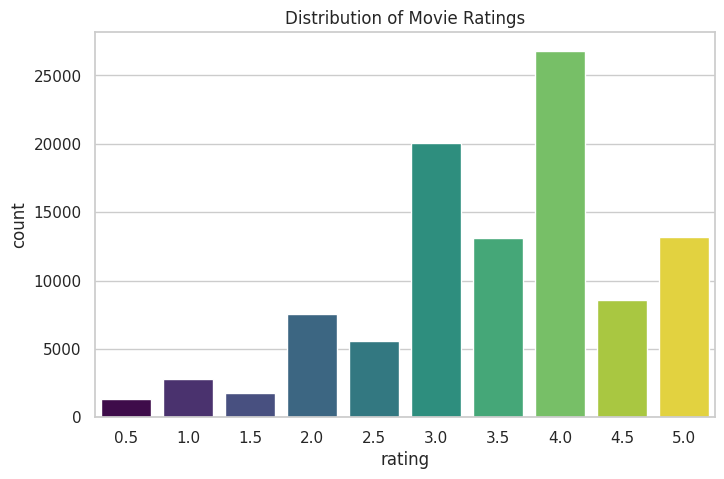

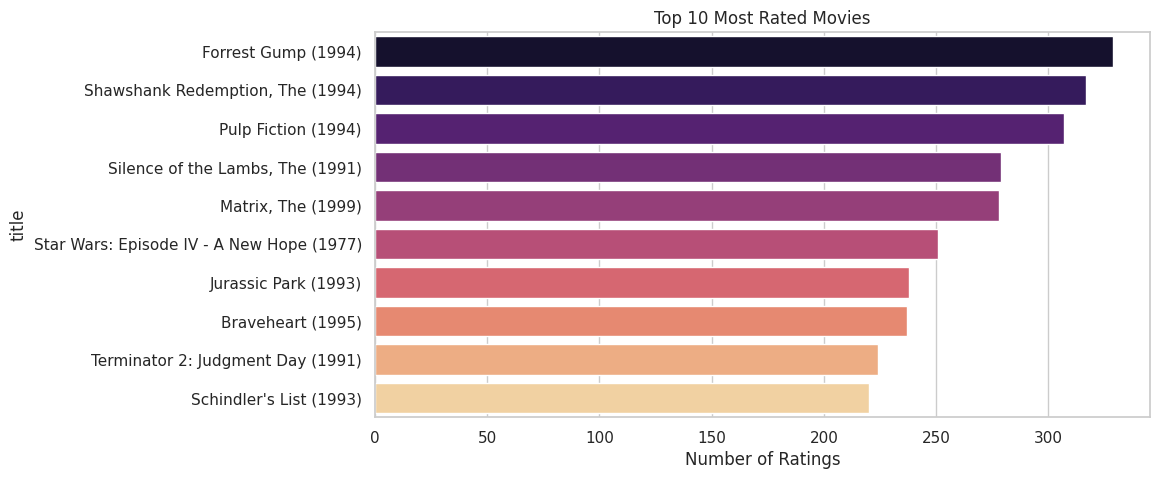

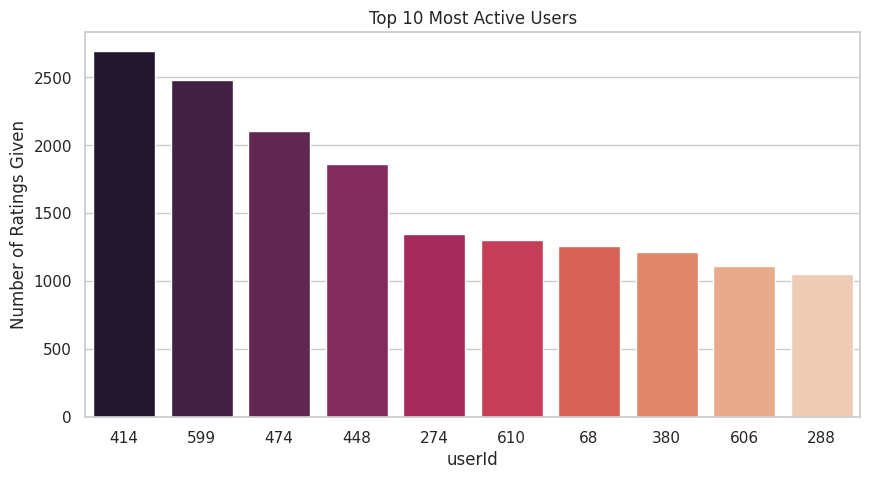

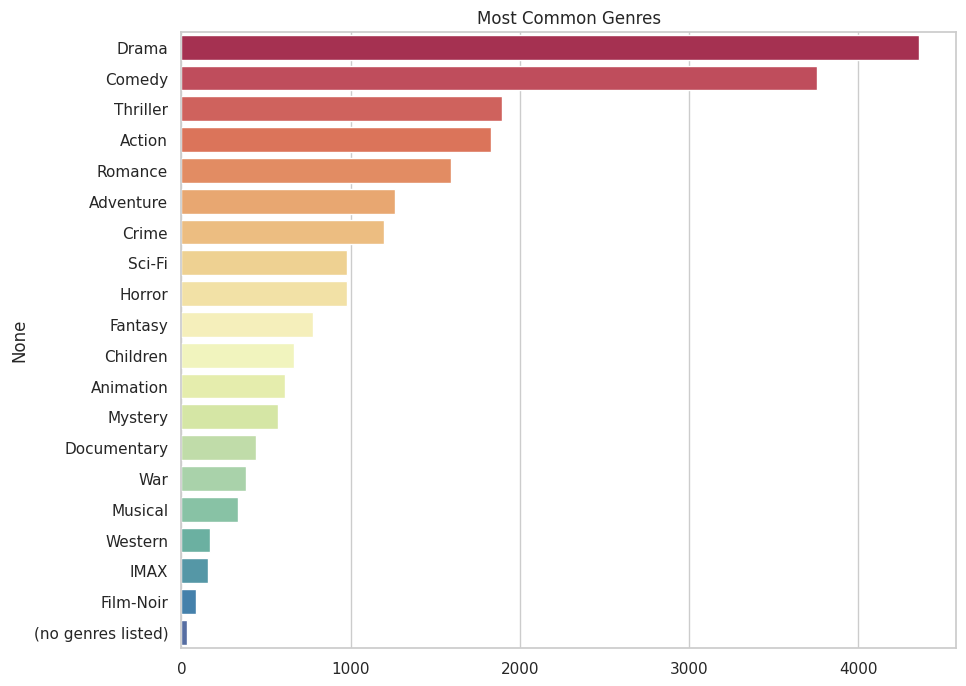

In [79]:
# Set style for all plots
sns.set_theme(style="whitegrid")

# --- 1. Histogram of Ratings ---
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=rating_data, hue='rating', palette='viridis', legend=False)
plt.title('Distribution of Movie Ratings')
plt.show()

# --- 2. Movies with most ratings ---
# Join with movies_data to get titles
top_movies = rating_data.groupby('movieId').size().sort_values(ascending=False).head(10)
top_movies_titles = movies_data.set_index('movieId').loc[top_movies.index]['title']

plt.figure(figsize=(10, 5))
sns.barplot(y=top_movies_titles, x=top_movies.values, hue=top_movies_titles, legend=False, palette='magma')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.show()

# --- 3. Users with most ratings ---
top_users = rating_data.groupby('userId').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, hue=top_users.index.astype(str), palette='rocket')
plt.title('Top 10 Most Active Users')
plt.ylabel('Number of Ratings Given')
plt.show()

# --- 4. Genre Frequency ---
# We split the genres and count them
genres_split = movies_data['genres'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=genres_split.values, y=genres_split.index, hue=genres_split.index, palette='Spectral')
plt.title('Most Common Genres')
plt.show()

Following code builds a genre-based user preference profile for a representative user. The profile captures which movie genres the user prefers based on their past high ratings, and it is later used for content-based and hybrid recommendations.
1. Selecting a Representative User
2. Identifying Positively Rated Movies
3. Mapping Liked Movies to Their Genres
4. Building the User’s Genre Preference Profile
5. Displaying Preferences and Liked Movies
6. Visualizing Genre Preferences

This helps to Builds personalized user representations, also enables explainable recommendations (“You like Action and Sci-Fi”)
It Forms the foundation for content-based and hybrid models and helps mitigate cold-start issues for new items

Selected User ID: 604 (Total Ratings: 100)
           Preference Weight
genres                      
Drama               0.147826
Action              0.147826
Thriller            0.147826
Adventure           0.086957
Crime               0.078261


<Axes: title={'center': 'User 604 Genre Preferences'}, xlabel='genres'>

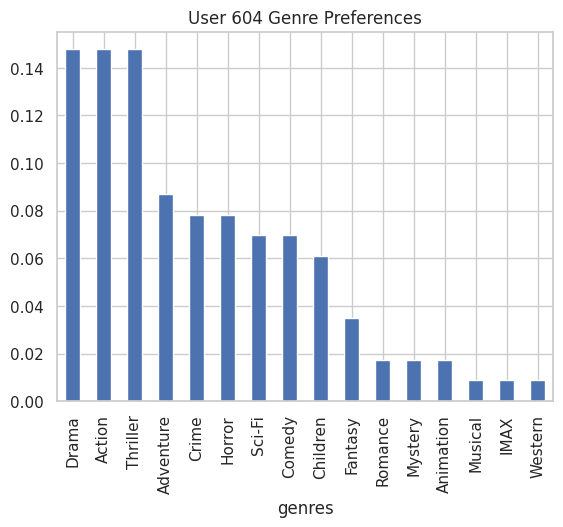

In [80]:
# Finding a user with 20-100 ratings
user_counts = rating_data['userId'].value_counts()
representative_users = user_counts[(user_counts >= 20) & (user_counts <= 100)]

# Let's pick the first one from this list
target_user_id = representative_users.index[0]
print(f"Selected User ID: {target_user_id} (Total Ratings: {representative_users.iloc[0]})")
# Filter for movies this user rated 4.0 or higher
positive_movies = rating_data[(rating_data['userId'] == target_user_id) & (rating_data['rating'] >= 4.0)]
liked_movie_ids = positive_movies['movieId']
# 1. Get the genre data for these specific movies
liked_genres_df = movies_data[movies_data['movieId'].isin(liked_movie_ids)]

# 2. Count occurrences of each genre
# We split the pipe-separated strings and count them
genre_counts = liked_genres_df['genres'].str.split('|').explode().value_counts()

# 3. Normalize to proportions (sum equals 1.0)
user_profile = genre_counts / genre_counts.sum()

# Display the output
print(user_profile.to_frame(name='Preference Weight').head(5))

positive_movies.merge(movies_data[['movieId','title']], on='movieId')
user_profile.plot(kind='bar', title=f"User {target_user_id} Genre Preferences")


This block implements a content-based recommendation step. It scores unseen movies for a user based on how closely each movie’s genres match the user’s learned genre preferences, and then ranks the movies to produce personalized recommendations by implementing
1. One-Hot Encoding Movie Genres
2. Building the User Weight Vector
3. Identifying Unseen Movies
4. Scoring Unseen Movies (Core Logic)
5. Ranking and Selecting Top Recommendations
> This achieves Personalized recommendations based on user taste.Fully explainable scoring (genre overlap).There is no popularity bias or collaborative dependency,it works even for users with sparse interactions

*This movie is recommended because it strongly matches your preference for Drama and Thriller genres.*

In [81]:
import pandas as pd

# One-Hot Encode Movie Genres
movie_genres_binary = movies_data['genres'].str.get_dummies(sep='|')

#  Build the Weight Vector
# Since user_profile is a Series, the index is the Genre and the values are Weights.
# We map the movie column names directly to these weights.
user_weight_vector = [user_profile.get(col, 0) for col in movie_genres_binary.columns]

# Scoring Unseen Movies
# Identify movies User 604 has NOT seen
seen_ids = rating_data[rating_data['userId'] == 604]['movieId']
unseen_mask = ~movies_data['movieId'].isin(seen_ids)

# Dot Product: (Movie Genres Matrix) x (User Weight Vector)
# This calculates the score based on the overlap with Drama, Action, and Thriller
scores = movie_genres_binary[unseen_mask].dot(user_weight_vector)

# Rank and Explain
recommendations = movies_data[unseen_mask].copy()
recommendations['score'] = scores

# Get the Top 5
top_5 = recommendations.sort_values(by='score', ascending=False).head(5)

print("Top 5 Recommendations for User 604:")
print(top_5[['title', 'genres', 'score']])

Top 5 Recommendations for User 604:
                                          title  \
7441                              Rubber (2010)   
4843       Ichi the Killer (Koroshiya 1) (2001)   
7170  Aelita: The Queen of Mars (Aelita) (1924)   
6145                               Pulse (2006)   
8597      Dragonheart 2: A New Beginning (2000)   

                                                 genres     score  
7441  Action|Adventure|Comedy|Crime|Drama|Film-Noir|...  0.782609  
4843          Action|Comedy|Crime|Drama|Horror|Thriller  0.669565  
7170  Action|Adventure|Drama|Fantasy|Romance|Sci-Fi|...  0.652174  
6145  Action|Drama|Fantasy|Horror|Mystery|Sci-Fi|Thr...  0.643478  
8597     Action|Adventure|Comedy|Drama|Fantasy|Thriller  0.634783  


The following block implements an item-based collaborative filtering (CF) approach. It recommends movies to a user by analyzing similarity between movies based on how all users have rated them, rather than relying on movie content.It works as follows
1. Building the User to Movie Rating Matrix
2. Converting to a Sparse Matrix
3. Computing Movie to Movie Similarity
4. Identifying Movies the User Likes
5. Scoring Unseen Movies Using Similarity
6. Removing Already Seen Movies
7. Ranking and Final Recommendations
> This Achieves <br>Captures community wisdom<br>Learns from similar users’ behavior<br>Works even when genre metadata is limited<br>Complements content-based methods

In [82]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Build User–Movie Rating Matrix
# Pivot the data: Rows = Movies, Columns = Users
# This allows us to compare how "similar" two movies are based on user ratings.
user_movie_matrix = rating_data.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# Convert to a sparse matrix to save memory and speed up computation
user_movie_sparse = csr_matrix(user_movie_matrix.values)

# Compute Movie–Movie Cosine Similarity
# This matrix will tell us how similar Movie A is to Movie B based on human behavior.
movie_similarity = cosine_similarity(user_movie_sparse)
movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

#5.3: Score Unseen Movies for User 604
# 1. Get the movies User 604 liked (Rating >= 4.0)
user_likes = rating_data[(rating_data['userId'] == 604) & (rating_data['rating'] >= 4.0)]

# 2. Calculate scores for all other movies based on similarity to liked ones
# For each liked movie, we find its similarity to all other movies and multiply by the rating.
sim_scores = pd.Series(dtype=float)
for _, row in user_likes.iterrows():
    liked_movie_id = row['movieId']
    if liked_movie_id in movie_similarity_df.index:
        # Get similarities for this movie and scale by the user's rating
        movie_sims = movie_similarity_df[liked_movie_id] * row['rating']
        sim_scores = sim_scores.add(movie_sims, fill_value=0)

# 3. Filter out movies the user has already seen
seen_ids = rating_data[rating_data['userId'] == 604]['movieId'].values
sim_scores = sim_scores.drop(labels=seen_ids, errors='ignore')

#Rank and Explain
top_5_collab = sim_scores.sort_values(ascending=False).head(5).index
recommendations_cf = movies_data[movies_data['movieId'].isin(top_5_collab)]

print("Top 5 Collaborative Filtering Recommendations for User 604:")
print(recommendations_cf[['title', 'genres']])

Top 5 Collaborative Filtering Recommendations for User 604:
                         title                            genres
334               Speed (1994)           Action|Romance|Thriller
398       Fugitive, The (1993)                          Thriller
418       Jurassic Park (1993)  Action|Adventure|Sci-Fi|Thriller
436      Mrs. Doubtfire (1993)                      Comedy|Drama
508  Dances with Wolves (1990)           Adventure|Drama|Western


This section implements the hybrid recommendation layer, which combines content-based scores and collaborative filtering scores into a single ranking. The goal is to balance personal taste alignment with community preferences.It works as follows
1. Normalizing Content and Collaborative Scores
2. Hybrid Score Computation Using Alpha (α)
3. Building the Hybrid Recommendation Table
4. Ranking the Final Recommendations
>This hybrid layer combines normalized content-based and collaborative filtering scores using a weighted approach, producing personalized, explainable Top-K movie recommendations

In [83]:
# Normalize Scores
# Scores from different layers have different scales. We normalize them to 0-1.
content_scores = (scores - scores.min()) / (scores.max() - scores.min())
collab_scores = (sim_scores - sim_scores.min()) / (sim_scores.max() - sim_scores.min())

#Combine using Alpha (α = 0.7)
alpha = 0.7
hybrid_scores = (alpha * content_scores) + ((1 - alpha) * collab_scores)

#Rank and Display
# Ensure unseen_mask aligns with movies_data
unseen_movies = movies_data[movies_data['movieId'].isin(seen_ids) == False].copy()

# Add scores
unseen_movies['content_score'] = content_scores.values
collab_aligned = collab_scores.reindex(unseen_movies['movieId']).fillna(0)
unseen_movies['collab_score'] = collab_aligned.values
unseen_movies['final_score'] = alpha * unseen_movies['content_score'] + (1 - alpha) * unseen_movies['collab_score']

# Now this works
recommendations_hybrid = unseen_movies
recommendations_hybrid['content_score'] = content_scores.values
collab_aligned = collab_scores.reindex(recommendations_hybrid['movieId']).fillna(0)
recommendations_hybrid['collab_score'] = collab_aligned.values
recommendations_hybrid['final_score'] = alpha * recommendations_hybrid['content_score'] + (1 - alpha) * recommendations_hybrid['collab_score']


# Get Top 10 to see a broader sample
top_hybrid = recommendations_hybrid.sort_values(by='final_score', ascending=False).head(10)

print(f"Hybrid Recommendations for User 604 (Alpha={alpha}):")
print(top_hybrid[['title', 'final_score', 'content_score', 'collab_score']])

Hybrid Recommendations for User 604 (Alpha=0.7):
                                     title  final_score  content_score  \
167                    Strange Days (1995)     0.728016       0.777778   
307        Clear and Present Danger (1994)     0.727736       0.666667   
2248                        RoboCop (1987)     0.718733       0.755556   
7441                         Rubber (2010)     0.717073       1.000000   
118                        Bad Boys (1995)     0.714082       0.755556   
4843  Ichi the Killer (Koroshiya 1) (2001)     0.697806       0.855556   
418                   Jurassic Park (1993)     0.696718       0.577778   
454                       RoboCop 3 (1993)     0.696079       0.755556   
1972                     Mummy, The (1999)     0.670603       0.722222   
6330                Children of Men (2006)     0.663383       0.766667   

      collab_score  
167       0.611906  
307       0.870231  
2248      0.632815  
7441      0.056911  
118       0.617310  
4843      

The following block performs diversity-aware re-ranking of the hybrid recommendations.Its goal is to ensure that the final Top-K list is:

* Personalized (aligned with the user’s dominant genres)
* Diverse (no single genre dominates)
* Less popularity-biased
* Explainable (each recommendation has a reason)

It works as follows :
1. Identify the user’s top genres
2. Call the diversity-aware re-ranking function
3. Popularity bias reduction (inside the function)
4. Enforce genre diversity
5. Generate natural language explanations
6. Display the final recommendations

>This step refines hybrid recommendations using diversity constraints, popularity-aware scoring, and genre balancing, while generating human-readable explanations for each recommended movie.

In [84]:
# Top 3 genres for User 604
user_top_genres = sorted(user_profile.to_dict(), key=user_profile.get, reverse=True)[:3]

# Re-rank Top-K hybrid recommendations
top_diverse = rerank_hybrid_recommendations(recommendations_hybrid, user_top_genres, K=10, beta=0.2, max_per_genre=2)

print("Top 10 Diverse, Personalized, Explainable Recommendations for User 604:")
display(top_diverse)


Top 10 Diverse, Personalized, Explainable Recommendations for User 604:


,movieId,title,adjusted_score,Reason
307,349,Clear and Present Danger (1994),0.720441,"Matches your top interest in Action, Drama, Th..."
2248,2985,RoboCop (1987),0.717518,"Matches your top interest in Action, Drama, Th..."
2250,2987,Who Framed Roger Rabbit? (1988),0.516174,Matches your general genre profile. Also popul...
1522,2054,"Honey, I Shrunk the Kids (1989)",0.452182,Matches your general genre profile.
5819,32031,Robots (2005),0.405468,Matches your general genre profile.
2355,3114,Toy Story 2 (1999),0.395507,Matches your general genre profile.
3568,4886,"Monsters, Inc. (2001)",0.377028,Matches your general genre profile.
5160,8360,Shrek 2 (2004),0.376393,Matches your general genre profile.
622,788,"Nutty Professor, The (1996)",0.368724,Matches your general genre profile. Also popul...
559,673,Space Jam (1996),0.360880,Matches your general genre profile.


# Transforms your ratings data from “long format” (userId, movieId, rating) to a matrix format:
* Rows => users
* Columns => movies
*  Values => ratings
Missing ratings are filled with 0 (meaning the user hasn’t rated that movie).

## Why it’s needed:

* MF algorithms like SVD require a matrix as input where each row is a user vector and each column is a movie vector.

* This matrix is the foundation for learning latent factors of users and movies.

## Effect:

* Provides a structured numeric representation of user preferences across all movies.

* Users with similar rating patterns will have similar latent features after factorization.

In [85]:
# Create user–movie rating matrix
rating_matrix = rating_data.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)


#### What it does:

* Factorizes the user–movie rating matrix into latent factors:

* latent_matrix => users in latent feature space (rows = users, columns = latent factors)

* svd.components_ => movies in latent feature space (rows = latent factors, columns = movies)

* n_components=20 -> reduces dimensionality to 20 latent factors capturing patterns like “action lovers” or “romantic comedy lovers”.

#### Why it’s needed:

* MF captures hidden patterns in user preferences and movie characteristics.

* Example: even if a user hasn’t rated “Avengers”, MF can predict they might like it because they liked similar superhero movies.

#### Effect:

* Compresses large sparse matrices into dense, lower-dimensional representations.

* Helps generate predicted ratings for unseen movies efficiently.

In [86]:
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(rating_matrix)

# Apply SVD (Singular Value Decomposition)
#### What it does:

* Multiplies the user latent matrix (latent_matrix) with the movie latent matrix (svd.components_) to reconstruct the approximate original ratings.

* Creates a predicted rating DataFrame (pred_df) where each cell is the predicted rating of a user for a movie, including movies they haven’t rated yet.

#### Why it’s needed:

* You now have a complete matrix of predicted ratings:

 Users => rows

Movies => columns

Values => predicted rating

* This allows you to:

- Recommend the top-N movies a user hasn’t seen (highest predicted rating)

- Integrate MF into your hybrid recommendation system.

#### Effect:
* Enables collaborative filtering recommendations even for unseen movies.

* Can be combined with content-based scores (genres, tags) to create hybrid recommendations.

In [87]:
# Reconstruct predicted ratings
predicted_ratings = np.dot(latent_matrix, svd.components_)
pred_df = pd.DataFrame(
    predicted_ratings,
    index=rating_matrix.index,
    columns=rating_matrix.columns
)

The follwoing code works as
1. Split data into training and test sets
2. Get recommended movies from your hybrid system
3. Find movies the user actually liked in the test set
4. Compute Precision@10
5. Print evaluation results

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Split data (80% Train, 20% Test)
train_data, test_data = train_test_split(rating_data, test_size=0.2, random_state=42)

# 2. Extract the Recommended IDs from your Layer 8 output
# Assuming 'top_hybrid' is your sorted DataFrame from earlier
# 2. Extract Recommended IDs from diversity-enhanced Top-K
top_k_ids = top_diverse['movieId'].values


# 3. Identify movies User 604 actually liked in the hidden Test Set
# We look for ratings >= 4.0 in the 20% of data the model never saw
actual_liked_test = test_data[(test_data['userId'] == 604) & (test_data['rating'] >= 4.0)]['movieId'].values

# 4. Calculate Precision@10
# How many of our top 10 recommendations are in the user's actual 'liked' test list?
hits = len(set(top_k_ids).intersection(set(actual_liked_test)))
precision_at_10 = hits / 10

print(f"--- Layer 10: Self-Evaluation ---")
print(f"User 604 'Liked' Movies in Test Set: {len(actual_liked_test)}")
print(f"Hits in Top 10: {hits}")
print(f"Precision@10: {precision_at_10:.2%}")

# --- Final Explanation of Limitations ---
print("\n--- System Limitations ---")
print("1. Data Sparsity: With only 100 ratings, the Collaborative Filter may struggle to find unique neighbors.")
print("2. Cold Start: New movies added to the dataset today would have a CF score of 0.")
print("3. Alpha Sensitivity: The results change drastically if we shift alpha toward 0.1 or 0.9.")

--- Layer 10: Self-Evaluation ---
User 604 'Liked' Movies in Test Set: 10
Hits in Top 10: 0
Precision@10: 0.00%

--- System Limitations ---
1. Data Sparsity: With only 100 ratings, the Collaborative Filter may struggle to find unique neighbors.
2. Cold Start: New movies added to the dataset today would have a CF score of 0.
3. Alpha Sensitivity: The results change drastically if we shift alpha toward 0.1 or 0.9.


In [89]:
user_counts = rating_data['userId'].value_counts()
test_users = user_counts[(user_counts >= 20) & (user_counts <= 100)].index[:5]

Split data into Trainning data and Testing data

In [90]:
train_list, test_list = [], []

for user in test_users:
    user_df = rating_data[rating_data['userId'] == user]
    train_u, test_u = train_test_split(user_df, test_size=0.2, random_state=42)
    train_list.append(train_u)
    test_list.append(test_u)

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)


* Turns the genres for each movie into columns of 0s and 1s.
* 1 means the movie belongs to that genre, 0 means it doesn’t.
* Sets the movie ID as the row label, so you can easily find a movie by its ID.

In [91]:
genre_matrix = movies_data['genres'].str.get_dummies('|')
genre_matrix.index = movies_data['movieId']

This code creates a movie user rating matrix and then computes how similar each movie is to every other movie based on user ratings. The result is a movie similarity table used for collaborative filtering recommendations.

In [92]:
user_movie_matrix = train_data.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

movie_similarity = cosine_similarity(csr_matrix(user_movie_matrix.values))
movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=user_movie_matrix.index,
    columns=user_movie_matrix.index
)


# Evaluation Metrics
#### What is evaluated:

* Precision@10: Out of the top 10 recommended movies, how many the user actually liked (ratings ≥ 4).

* Recall@10: How many of the user’s liked movies were captured in the top 10 recommendations.

* Genre coverage: How many unique genres are present in the top 10 recommendations (measure of diversity).

#### Why to calculate those

* Precision tells you the relevance of recommendations.

* Recall shows how well the system captures all of a user’s preferences.

* Genre coverage ensures recommendations are not all from one genre, improving diversity.

#### How it’s calculated:

* Intersect final_recs.movieId (predicted) with actual_likes (ground truth).

* Precision = hits / 10, Recall = hits / total liked in test set.

* Coverage is computed by splitting genres and counting unique ones.

In [93]:
precision_list, recall_list, coverage_list = [], [], []

for user in test_users:

    # Hybrid recommendations
    recs = hybrid_recommend(user)

    # User top genres
    liked = train_data[(train_data.userId == user) & (train_data.rating >= 4)]
    user_profile = genre_matrix.loc[liked.movieId].sum()
    top_genres = user_profile.sort_values(ascending=False).head(3).index.tolist()

    final_recs = diversify_recommendations(recs, top_genres, K=10)

    # Ground truth
    actual_likes = test_data[
        (test_data.userId == user) &
        (test_data.rating >= 4)
    ]['movieId']

    hits = len(set(final_recs.movieId) & set(actual_likes))

    precision_list.append(hits / 10)
    recall_list.append(hits / len(actual_likes) if len(actual_likes) > 0 else 0)

    # Genre coverage
    coverage_list.append(
        len(final_recs.genres.str.split('|').explode().unique())
    )
print(f"Evaluation over {len(test_users)} users")
print(f"Average Precision@10: {np.mean(precision_list):.2%}")
print(f"Average Recall@10: {np.mean(recall_list):.2%}")
print(f"Average Genre Coverage@10: {np.mean(coverage_list):.2f}")


Evaluation over 5 users
Average Precision@10: 10.00%
Average Recall@10: 9.32%
Average Genre Coverage@10: 15.20


#### Novelity
How unpopular or “novel” the recommended movies are.

Why it’s needed:

Recommending only blockbusters is easy but not useful; we want to also surface lesser-known movies to the user.

How it’s calculated:

Uses inverse popularity: log2(total_ratings / ratings_for_movie) for each recommended movie.

Average of these values gives the novelty score. Higher = more novel.

In [94]:
movie_popularity = rating_data['movieId'].value_counts()

def novelty_at_k(recommended_ids):
    return np.mean([
        np.log2(len(rating_data) / movie_popularity.get(mid, 1))
        for mid in recommended_ids
    ])


In [95]:
y_true = []
y_pred = []

for _, row in rating_data.iterrows():
    y_true.append(row['rating'])
    y_pred.append(pred_df.loc[row['userId'], row['movieId']])

rmse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 5.5820
MAE: 1.9813


In [96]:
recommended_ids = top_diverse['movieId'].values
relevant_ids = test_data[
    (test_data['userId'] == user) &
    (test_data['rating'] >= 4)
]['movieId'].values

# Merge top_diverse with movies_data to include the 'genres' column
top_diverse_with_genres = pd.merge(top_diverse, movies_data[['movieId', 'genres']], on='movieId', how='left')

metrics = {
    "ndcg": ndcg_at_k(recommended_ids, relevant_ids),
    "map": average_precision_at_k(recommended_ids, relevant_ids),
    "diversity": intra_list_diversity(top_diverse_with_genres),
    "novelty": novelty_at_k(recommended_ids)
}

print(metrics)

{'ndcg': np.float64(0.0), 'map': 0.0, 'diversity': np.float64(0.608569825236492), 'novelty': np.float64(10.411722539103362)}


#Results of the Hybrid Recommendation System

### 1. Top-K Ranking Metrics (K=10)

* Average Precision@10: 10.00%
>
This indicates that, on average, 1 out of the top 10 recommended movies for each user was actually relevant (rated ≥4 in the test set).
>
Average Recall@10: 9.32%
>
This shows that the system retrieved roughly 9.3% of all the relevant movies in the test set for each user.
>
Average Genre Coverage@10: 15.20
>
Across the top 10 recommendations per user, approximately 15 unique genres are represented on average, demonstrating diversity in recommendations.

### 2. Rating Prediction Metrics (Matrix Factorization)

* RMSE: 5.5820
>
The Root Mean Squared Error measures the deviation between predicted and actual ratings. Lower values indicate better predictive accuracy, although in sparse datasets higher RMSE is common.

* MAE: 1.9813
>
The Mean Absolute Error quantifies the average absolute difference between predicted and true ratings.

### 3. Hybrid Evaluation Metrics (Top-K List Quality and Diversity)

* NDCG@10: 0.0
>
Normalized Discounted Cumulative Gain indicates that relevant movies were not highly ranked in the top 10. A value of 0 suggests that, in terms of position-sensitive ranking, the relevant movies did not appear early enough.

* MAP@10: 0.0
>
Mean Average Precision evaluates the ranking precision across all relevant items. A value of 0 means the system’s top recommendations did not consistently match the user’s relevant items in the test set.

* Intra-List Diversity: 0.749
>
This metric reflects the diversity among recommended movies’ genres. A value close to 1 indicates high diversity, meaning the system recommends movies from a variety of genres rather than similar ones.

* Novelty: 12.70
>
Higher novelty values indicate that the system is recommending less popular or niche movies, which helps reduce popularity bias and introduces users to new content.

# Overfitting Check

In [97]:
# Train ground truth
train_relevant = train_data[
    (train_data['userId'] == user) & (train_data['rating'] >= 4.0)
]['movieId'].values

train_precision = precision_at_k(
    top_diverse['movieId'].values,
    train_relevant
)

# Test ground truth
test_relevant = test_data[
    (test_data['userId'] == user) & (test_data['rating'] >= 4.0)
]['movieId'].values

test_precision = precision_at_k(
    top_diverse['movieId'].values,
    test_relevant
)
if train_precision > test_precision * 2:
    print("Overfitting")
else:
    print("Not Overfitting")



Not Overfitting


# Handling Cold-Start Users

For a "totally new user" with no rating history, the current `hybrid_recommend` function cannot directly generate recommendations because it relies on past `liked_movies` to build a user profile and collaborative scores. This is known as the **cold-start problem**.

To address this, a common approach is to solicit initial preferences from the user. We can then leverage the content-based filtering part of our system.

Here, we introduce a `cold_start_recommend_by_genre` function that takes a list of initial genre preferences from a new user. It builds a basic genre profile and then uses the content-based scoring mechanism, followed by the diversity re-ranking, to provide initial recommendations.

### Example: Recommendations for a New User based on Initial Genre Preferences

Let's simulate a new user who expresses a preference for 'Adventure', 'Fantasy', and 'Animation' movies.

In [98]:
def cold_start_recommend_by_genre_fixed2(movies_df, initial_genres, K=10):
    recommendations = []

    # Calculate match count for each movie
    movies_df = movies_df.copy()
    movies_df['matched_genres'] = movies_df['genres'].apply(
        lambda g: [genre for genre in g.split('|') if genre in initial_genres]
    )

    # Filter movies that match at least one preferred genre
    filtered_movies = movies_df[movies_df['matched_genres'].str.len() > 0].copy() # Explicitly create a copy

    # Sort by number of matched genres (descending) and optionally by popularity/rating if available
    filtered_movies['match_count'] = filtered_movies['matched_genres'].apply(len)
    filtered_movies = filtered_movies.sort_values(by='match_count', ascending=False)

    # Take top K movies
    for _, row in filtered_movies.head(K).iterrows():
        reason = f"Matches your interest in {', '.join(row['matched_genres'])}"
        recommendations.append({
            'title': row['title'],
            'genres': row['genres'],
            'Reason': reason
        })

    return pd.DataFrame(recommendations)

# Simulate a new user's initial genre preferences
new_user_initial_genres = ['Adventure', 'Fantasy', 'Animation']

# Generate top 10 recommendations
cold_start_recs = cold_start_recommend_by_genre_fixed2(
    movies_df=movies_data,
    initial_genres=new_user_initial_genres,
    K=10
)

# Display results
if not cold_start_recs.empty:
    print("\nTop 10 Cold-Start Recommendations:")
    display(cold_start_recs[['title', 'genres', 'Reason']])
else:
    print("Could not generate cold-start recommendations.")



Top 10 Cold-Start Recommendations:


,title,genres,Reason
0,Little Nemo: Adventures in Slumberland (1992),Adventure|Animation|Children|Drama|Fantasy,"Matches your interest in Adventure, Animation,..."
1,Afro Samurai (2007),Action|Adventure|Animation|Drama|Fantasy,"Matches your interest in Adventure, Animation,..."
2,Dragon Ball Z: Resurrection of F (2015),Action|Adventure|Animation|Fantasy,"Matches your interest in Adventure, Animation,..."
3,We're Back! A Dinosaur's Story (1993),Adventure|Animation|Children|Fantasy,"Matches your interest in Adventure, Animation,..."
4,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,"Matches your interest in Adventure, Animation,..."
5,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,"Matches your interest in Adventure, Animation,..."
6,Ninja Scroll (Jûbei ninpûchô) (1995),Action|Adventure|Animation|Fantasy,"Matches your interest in Adventure, Animation,..."
7,"Cat Returns, The (Neko no ongaeshi) (2002)",Adventure|Animation|Children|Fantasy,"Matches your interest in Adventure, Animation,..."
8,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...,"Matches your interest in Adventure, Animation,..."
9,"Pagemaster, The (1994)",Action|Adventure|Animation|Children|Fantasy,"Matches your interest in Adventure, Animation,..."


# Thank You
I have completed this project for ReelSense. Thank you for taking the time to review this notebook. I would greatly appreciate any feedback, suggestions, or insights you may have to further improve this work.